# [Plant Pathology 2020 - FGVC7](https://www.kaggle.com/c/plant-pathology-2020-fgvc7/overview)
*Identify the category of foliar diseases in apple trees*


This notebook run on Google Colab

## Setup connect with Drive

- Tree
    - Deeplearning
        - train.csv
        - test.csv
        - notebook.ipynb

In [ ]:
# Check the GPU is available, if not, swith other account to have usefulness of GPU
import torch
torch.cuda.is_available()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Go to directory
import os
os.chdir('./drive/MyDrive/Deeplearning')

# Read dataset

In [ ]:
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

In [ ]:
train_csv_path = './train.csv'
train_info = pd.read_csv(train_csv_path)
train_info.head()

In [ ]:
quantity = train_info.describe()
quantity

- The number sample of each class is skewed
- class_weight will use with the criterion to compute the loss which view as "balance"

In [ ]:
class_weight = (quantity.loc['mean'].max() / quantity.loc['mean']).values
class_weight

In [ ]:
id_images = train_info['image_id'].values
labels = train_info.iloc[:, 1:].values
labels = labels.argmax(axis = 1)

## Define the Dataset

- During training time, I use the some data augment as:
    - Blur with kernel size 11
    - Change the perspective
    - Rotate with degree between 0 and 180
    - Increase/decrease the contrast of image
    - Flip the image both H/V side
- During validation/test time, data augment will turn off

In [ ]:
image_path = './images'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((320, 512))
])

augment = transforms.RandomApply(transforms = [transforms.GaussianBlur(11),
                                         transforms.RandomPerspective(),
                                         transforms.RandomRotation(degrees=(0, 180)),
                                         transforms.RandomAutocontrast(),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.RandomVerticalFlip()])

class PurePlantDataset(Dataset):
    def __init__(self, ids, labels, transform, augment = None):
        
        super(PurePlantDataset, self).__init__()
        self.cache = {}
        self.transform = transform
        self.augment = augment
        self.ids = ids
        self.labels = labels
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, index):
        image = self.cache.get(index, None)
        if image == None:
            image_name = os.path.join(image_path, self.ids[index] + '.jpg')
            image = Image.open(image_name)
            image = self.transform(image)
            self.cache[index] = image
        
        if self.augment != None:
            return self.augment(image), self.labels[index]
        return image, self.labels[index]

## Define network

- I use the resnet as backbone of the network and simple classifier layer "Linear"
- Accept the net: resnet50, resnet101, resnet152. And in this project I just test with resnet 50
- The size of the resnet on my local, but in Colab the size will larger (I unenough time to know what happen :D, reader can test and slove this problem)
    - resnet50: 730M
    - resnet101: 784M
    - resnet152: 856M
- The Identity layer is a dummy. I plant to freeze the backbone and use it as feature extraction layer, but when training the accuracy is limitted around 0.88, so I unfeeze the backbone and get the better result. This implement can change directly the fc in resnet by the Linear.
- The last layer we don't use activation function, it will be combined with CrossEntropyLoss later

In [ ]:
from torchvision import models

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, X):
        return X

class ResnetModel(nn.Module):
    def __init__(self, backbone, n_class):
        super(ResnetModel, self).__init__()
        if backbone == 'resnet50':
            self.backbone = models.resnet50(pretrained=True)
        elif backbone == 'resnet101':
            self.backbone = models.resnet101(pretrained=True)
        elif backbone == 'resnet152':
            self.backbone = models.resnet152(pretrained=True)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = Identity()
        
        self.fc = nn.Linear(in_features, n_class)
    def forward(self, X):
        out = self.backbone(X)
        return self.fc(out)

## Training

In [ ]:
n_epoch = 20
lr = 1e-2
batch_size = 32
n_fold = 5 # test size 0.2
global_device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def get_accuracy(logit, y_truth):
    logit = torch.softmax(logit, dim = 1)
    y_predict = logit.argmax(dim = 1)
    return torch.sum(y_predict == y_truth) / len(y_truth)

def evaluate(model, criterion, test_loader):
    with torch.no_grad():
        losses = []
        accs = []
        for X, Y in test_loader:
            X = X.to(device = global_device)
            Y = Y.to(device = global_device)
            out = model(X)
            loss = criterion(out.detach(), Y).item() if criterion != None else -1
            acc = get_accuracy(out.detach(), Y)
            
            losses.append(loss)
            accs.append(acc.item())
        return sum(losses)/len(losses), sum(accs)/len(accs)

In [ ]:
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import StratifiedKFold


freeze = False
checkpoint_path = 'model_resnet50.pt'
continue_training = False

spliter = StratifiedKFold(n_splits=n_fold, shuffle=True)
best_score = 0
for i, (train_idx, val_idx) in enumerate(spliter.split(id_images, labels)):
    print(f"Train in fold {i}============================================")
    train_data = PurePlantDataset(ids=id_images[train_idx], 
                                    labels = labels[train_idx], 
                                    transform = transform, 
                                    augment = augment)
    val_data = PurePlantDataset(ids=id_images[val_idx], 
                                    labels = labels[val_idx], 
                                    transform = transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)
    
    model = ResnetModel('resnet50', 4)
    model.to(device = global_device)
    if freeze == True:
        for param in model.backbone.parameters():
            param.requires_grad = False

    opt_param = [param for param in model.parameters() if param.requires_grad == True]
    optimizer = torch.optim.Adam(params=opt_param, lr=lr)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    if os.path.exists(checkpoint_path) & continue_training:
        checkpoint = torch.load(checkpoint_path, map_location=global_device)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        best_score = checkpoint['best_score']
        print("Load state dict")
    
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weight, dtype=torch.float, device=global_device))
    for epoch in range(n_epoch):
        print(f"Train epoch {epoch}/{n_epoch}...")
        total_loss = []
        total_acc = []
        
        model.train()
        for X, Y in tqdm(train_loader):
            optimizer.zero_grad()
            X = X.to(device = global_device)
            Y = Y.to(device = global_device)
            out = model(X)
            loss = criterion(out, Y)
            loss.backward()
            optimizer.step()
            
            total_loss.append(loss.item())
            acc = get_accuracy(out.detach(), Y)
            total_acc.append(acc.item())
        
        model.eval()
        avg_train_loss = sum(total_loss) / len(total_loss)
        avg_train_acc = sum(total_acc) / len(total_acc)
        val_loss, val_acc = evaluate(model, criterion, val_loader)
        print(f"Train loss {avg_train_loss:.4f} accuray {avg_train_acc:.4f}. Val loss {val_loss:.4f} accuracy {val_acc:.4f}")
        
        if val_acc >= best_score:
            best_score = val_acc
            torch.save({
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'best_score': best_score
            }, checkpoint_path)
            print("Save---")
        scheduler.step()
    break # train on fold 0


## Test all sample before submit

In [ ]:
def load_model_pretrain(mode, path, device):
    model = ResnetModel(mode, 4)
    model.to(device=global_device)

    checkpoint = torch.load(path, map_location=device)
    model.to(device=device)
    model.load_state_dict(checkpoint['model'])
    return model
  

In [ ]:
eval_data = PurePlantDataset(ids=id_images, labels = labels, transform = transform)
eval_loader = DataLoader(eval_data, batch_size=32, shuffle=True)

model = load_model_pretrain('resnet50', 'model_resnet50.pt', global_device)
model.eval()

evaluate(model, None, eval_loader)

## Submition

In [ ]:
model = ResnetModel('resnet50', 4)
model.to(device=global_device)

checkpoint =torch.load('model_resnet50.pt', map_location=global_device)
model.load_state_dict(checkpoint['model'])
model.eval()

In [ ]:
df = pd.read_csv('test.csv')
df.head()

In [ ]:
for title in train_info.columns[1:]:
    df[title] = np.NaN
for i, id_image in enumerate(df.image_id):
    image_name = os.path.join(image_path, id_image + '.jpg')
    image = Image.open(image_name)
    image = transform(image)
    image = image.to(device = global_device)
    output = model(image.unsqueeze(0))
    logit = torch.softmax(output.detach().cpu(), dim = 1)
    
    round_logit = [round(l, 2) for l in logit.squeeze().tolist()]
    df.iloc[i, 1:] = round_logit

In [ ]:
df.head()

In [ ]:
df.to_csv("PhamQuocHuy_supmission.csv", index=False)

- Despite of the competition is off, the score is pretty cool (0o0)

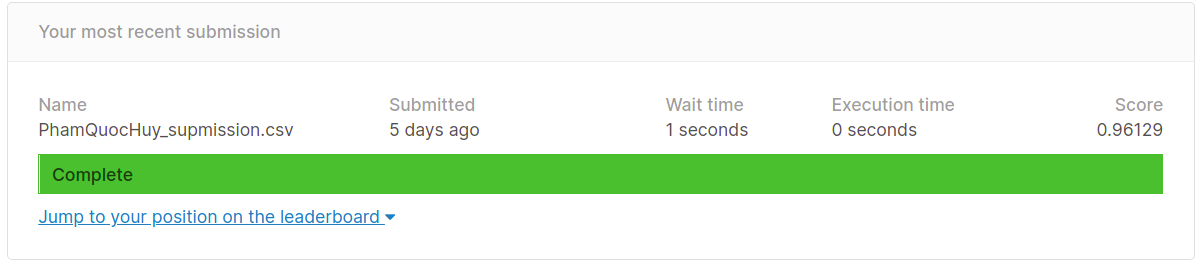

## Tips for training with Google Colab

- There are many tool, but I simply make small script on colab site

#Focus

- Open soucre of site: focus on this tab, right-click on "+ Text" to inspect
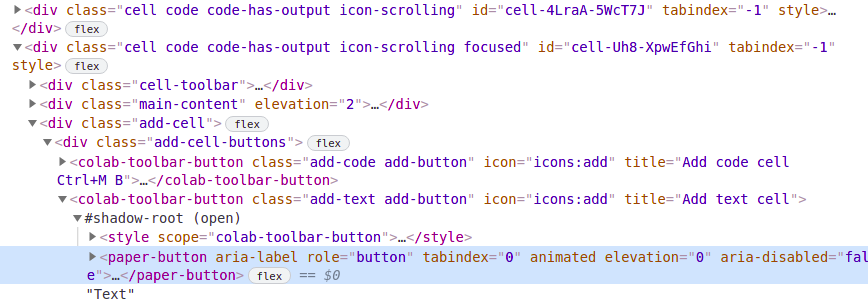
- Copy the id of tag with focused
- On the Console tab, make pretty scipt (^^) with id haved been coppied. Follow the example

`setInterval(() => {
    document.querySelector("#cell-Uh8-XpwEfGhi .add-text").click()
}, 600000)`

- This script will add 1 tab every 10 minutes
- Clear the output of setInterval `clearInterval(#output_of_setInterval)`
